In [44]:
'''
This is a sandbox to work on proving that we can get digital 
sound out of scans of an optical track. If I can manually 
get it to work here, I can then take this PoC and turn it into
a full application.
'''
import cv2
import os
import matplotlib.pyplot as plt
import math
import numpy as np

4056
4056


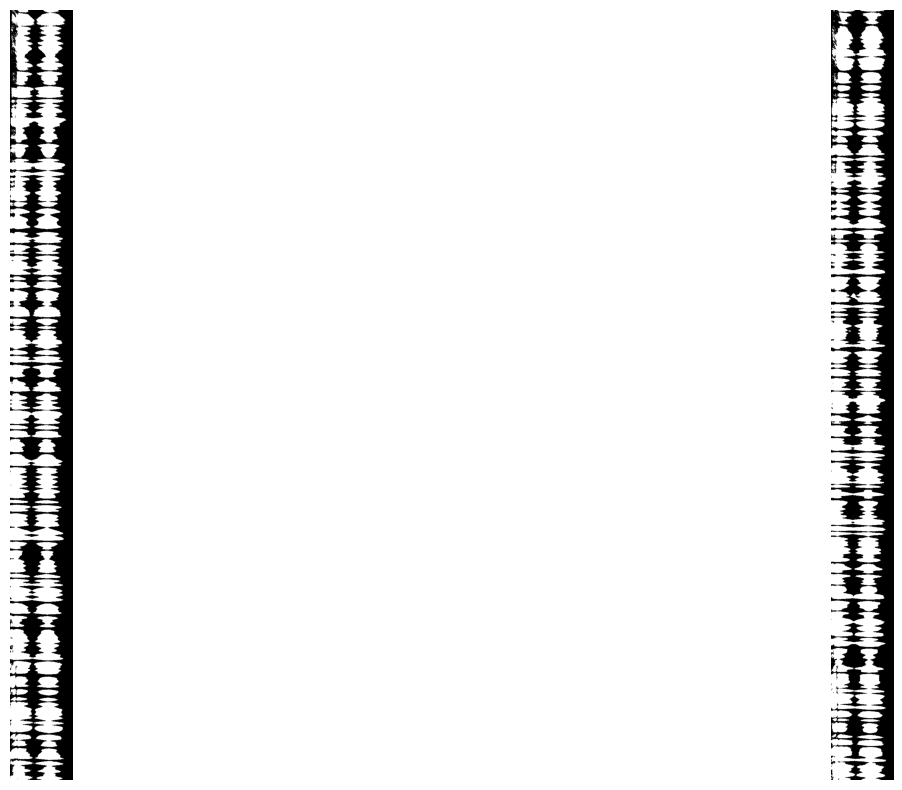

In [100]:
imagefiles = os.listdir("input\onesec\.")
imagefiles.sort()

images = []
cutoff = 0
for filename in imagefiles:
    if cutoff > 1:
        break

    img = cv2.imread("input\onesec\\" + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Default reads in as BGR, we want this as black and white
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    
    # Adjusts the brightness by adding 10 to each pixel value 
    brightness = 5
    # Adjusts the contrast by scaling the pixel values by 2.3 
    contrast = 3 
    img = cv2.addWeighted(img, contrast, np.zeros(img.shape, img.dtype), 0, brightness) 

    # Create the sharpening kernel
    kernel = np.array([[-1,-1,-1], 
                       [-1,9,-1], 
                       [-1,-1,-1]])
    # Apply the sharpening kernel to the image using filter2D
    img = cv2.filter2D(img, -1, kernel)

    height,width = img.shape
    print(height)
    #img = img[700:height-1000,400:width-2000]

    # This gets just full soundtrack
    # img = img[700:height-1000,500:width-2350] # just trimming the image
    img = img[700:height-1000,500:width-1000] # just trimming the image
    
    # Rotate back
    # img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Make pixel 1 or 0, "thresholding". This is how we make the optical track either black or white
    ret,img = cv2.threshold(img,254,255,cv2.THRESH_BINARY)

    images.append(img)
    cutoff = cutoff + 1
num_images = len(images)

images = images[::-1] # Reverse the list order to get the expected order of the optical tracks

plt.figure(figsize=[30,10])
num_cols = 3
num_rows = math.ceil(num_images / num_cols)
for i in range(0, num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.axis('off')
    plt.imshow(images[i], cmap='gray') # matplot reads the channels as RGB, so we need to tell it this is actually grey or we get weird channel issues

## Now we try to find overlap

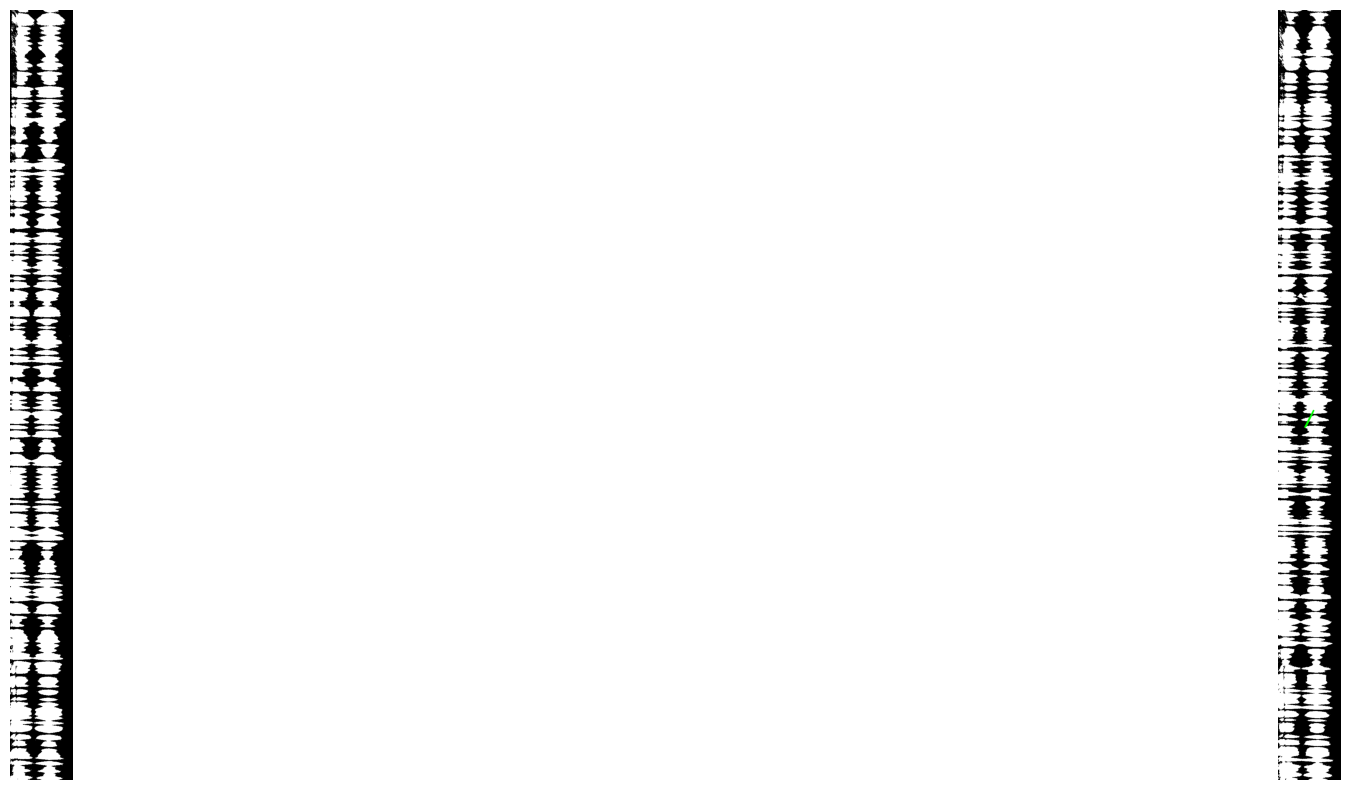

In [102]:
image1 = images[0]
image2 = images[1]

# Convert the images to grayscale
gray1 = image1
gray2 = image2

# Perform feature detection and matching
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Match descriptors using FLANN
matcher = cv2.FlannBasedMatcher_create()
matches = matcher.match(descriptors1, descriptors2)

# Sort the matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

# Get the keypoints from the good matches
points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Find the homography matrix
H, _ = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

# Get the corners of the image1
h, w = image1.shape[:2]
corners1 = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)

# Transform the corners using the homography matrix
corners2 = cv2.perspectiveTransform(corners1, H)

# Draw the overlapping region
image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
image2 = cv2.polylines(image2, [np.int32(corners2)], True, (0, 255, 0), 3)

# Display the result
plt.figure(figsize=[30,10])
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image1, cmap='gray') # 
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image2, cmap='gray') # 

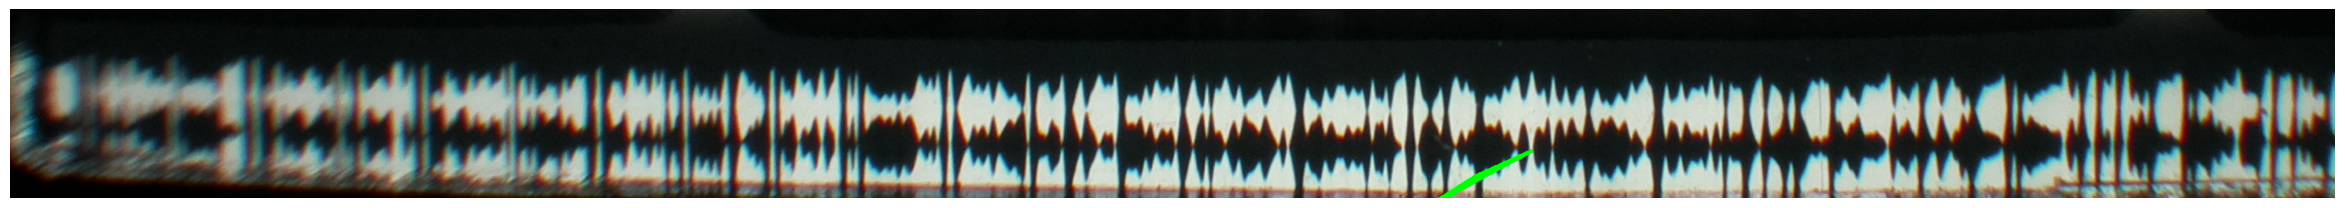

In [80]:
# Overlap region example
# Load the two images
image1 = cv2.imread('input\onesec\extrailer27.jpeg')
image2 = cv2.imread('input\onesec\extrailer28.jpeg')

image1 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
image2 = cv2.rotate(image2, cv2.ROTATE_90_CLOCKWISE)

height,width,chan = image1.shape
image1 = image1[100:height-1000,500:width-2300] # just trimming the image
image2 = image2[100:height-1000,500:width-2300] # just trimming the image

image1 = cv2.rotate(image1, cv2.ROTATE_90_COUNTERCLOCKWISE)
image2 = cv2.rotate(image2, cv2.ROTATE_90_COUNTERCLOCKWISE)


# Convert the images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

ret,gray1 = cv2.threshold(gray1,200,255,cv2.THRESH_BINARY)
ret,gray2 = cv2.threshold(gray2,200,255,cv2.THRESH_BINARY)

# Perform feature detection and matching
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Match descriptors using FLANN
matcher = cv2.FlannBasedMatcher_create()
matches = matcher.match(descriptors1, descriptors2)

# Sort the matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

# Get the keypoints from the good matches
points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Find the homography matrix
H, _ = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

# Get the corners of the image1
h, w = image1.shape[:2]
corners1 = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)

# Transform the corners using the homography matrix
corners2 = cv2.perspectiveTransform(corners1, H)

# Draw the overlapping region
image2 = cv2.polylines(image2, [np.int32(corners2)], True, (0, 255, 0), 3)

# Display the result
plt.figure(figsize=[30,10])
plt.axis('off')
plt.imshow(image2, cmap='gray') # 